Training model on the L1 dataset.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_L1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_L.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_L.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


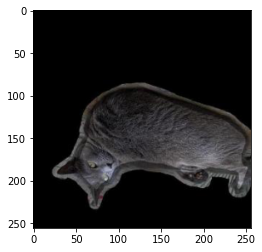

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [6]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.001
decay_rate = 0.0005
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

Epoch:8
Iteration:1400
Time taken for the last 50 iterations: 35.15483832359314
Current training loss:2.9091408252716064
Current training accuracy:0.21728515625
Current validation loss:2.9588727951049805
Current validation accuracy:0.16648530960083008
Epoch:8
Iteration:1450
Time taken for the last 50 iterations: 35.48652529716492
Current training loss:2.9743106365203857
Current training accuracy:0.193359375
Current validation loss:2.990539312362671
Current validation accuracy:0.15886832773685455
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 35.08460283279419
Current training loss:2.897648572921753
Current training accuracy:0.20556640625
Current validation loss:2.9881210327148438
Current validation accuracy:0.17627856135368347
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 35.45914316177368
Current training loss:2.9113080501556396
Current training accuracy:0.2080078125
Current validation loss:2.9839863777160645
Current validation accuracy:0.166485309600830

Epoch:17
Iteration:3050
Time taken for the last 50 iterations: 35.53252363204956
Current training loss:2.34602427482605
Current training accuracy:0.3583984375
Current validation loss:2.5169789791107178
Current validation accuracy:0.28291621804237366
Epoch:17
Iteration:3100
Time taken for the last 50 iterations: 35.19081139564514
Current training loss:2.3274965286254883
Current training accuracy:0.36328125
Current validation loss:2.5391597747802734
Current validation accuracy:0.2916213274002075
Epoch:18
Iteration:3150
Time taken for the last 50 iterations: 35.454837799072266
Current training loss:2.385582447052002
Current training accuracy:0.34765625
Current validation loss:2.5621230602264404
Current validation accuracy:0.26877039670944214
Epoch:18
Iteration:3200
Time taken for the last 50 iterations: 35.63589310646057
Current training loss:2.3234548568725586
Current training accuracy:0.37548828125
Current validation loss:2.518857002258301
Current validation accuracy:0.277475506067276
E

Epoch:27
Iteration:4700
Time taken for the last 50 iterations: 35.53678750991821
Current training loss:2.058717727661133
Current training accuracy:0.43896484375
Current validation loss:2.3569962978363037
Current validation accuracy:0.31882479786872864
Epoch:27
Iteration:4750
Time taken for the last 50 iterations: 35.594276666641235
Current training loss:2.0286238193511963
Current training accuracy:0.45556640625
Current validation loss:2.30839467048645
Current validation accuracy:0.3351469039916992
Epoch:27
Iteration:4800
Time taken for the last 50 iterations: 35.44010877609253
Current training loss:2.049741506576538
Current training accuracy:0.4423828125
Current validation loss:2.3768646717071533
Current validation accuracy:0.31664854288101196
Epoch:27
Iteration:4850
Time taken for the last 50 iterations: 35.572258949279785
Current training loss:2.0242843627929688
Current training accuracy:0.45068359375
Current validation loss:2.319222927093506
Current validation accuracy:0.32535365223

Epoch:36
Iteration:6350
Time taken for the last 50 iterations: 35.62199902534485
Current training loss:1.8672728538513184
Current training accuracy:0.48388671875
Current validation loss:2.2809746265411377
Current validation accuracy:0.341675728559494
Epoch:36
Iteration:6400
Time taken for the last 50 iterations: 35.69784188270569
Current training loss:1.85181725025177
Current training accuracy:0.4912109375
Current validation loss:2.2313809394836426
Current validation accuracy:0.3514689803123474
Epoch:37
Iteration:6450
Time taken for the last 50 iterations: 35.504969120025635
Current training loss:1.7529664039611816
Current training accuracy:0.5625
Current validation loss:2.1771178245544434
Current validation accuracy:0.36996734142303467
Epoch:37
Iteration:6500
Time taken for the last 50 iterations: 35.65214729309082
Current training loss:1.7766650915145874
Current training accuracy:0.52197265625
Current validation loss:2.2381277084350586
Current validation accuracy:0.3471164405345917
E

Current validation loss:2.166332960128784
Current validation accuracy:0.3971708416938782
Epoch:45
Iteration:8000
Time taken for the last 50 iterations: 37.39620232582092
Current training loss:1.5824470520019531
Current training accuracy:0.5859375
Current validation loss:2.1342825889587402
Current validation accuracy:0.38302502036094666
Epoch:46
Iteration:8050
Time taken for the last 50 iterations: 40.335108280181885
Current training loss:1.698205590248108
Current training accuracy:0.58203125
Current validation loss:2.218214988708496
Current validation accuracy:0.3819368779659271
Epoch:46
Iteration:8100
Time taken for the last 50 iterations: 38.54881691932678
Current training loss:1.6118848323822021
Current training accuracy:0.59814453125
Current validation loss:2.11842942237854
Current validation accuracy:0.3884657323360443
Epoch:46
Iteration:8150
Time taken for the last 50 iterations: 36.6853141784668
Current training loss:1.607553243637085
Current training accuracy:0.59375
Current va

Current validation loss:2.1206767559051514
Current validation accuracy:0.3786724805831909
Epoch:55
Iteration:9650
Time taken for the last 50 iterations: 34.57942008972168
Current training loss:1.4624603986740112
Current training accuracy:0.6318359375
Current validation loss:2.1227943897247314
Current validation accuracy:0.367791086435318
Epoch:55
Iteration:9700
Time taken for the last 50 iterations: 35.757161378860474
Current training loss:1.507802963256836
Current training accuracy:0.6357421875
Current validation loss:2.153973340988159
Current validation accuracy:0.36670294404029846
Epoch:56
Iteration:9750
Time taken for the last 50 iterations: 39.09588098526001
Current training loss:1.5297845602035522
Current training accuracy:0.62255859375
Current validation loss:2.1331334114074707
Current validation accuracy:0.3645266592502594
Epoch:56
Iteration:9800
Time taken for the last 50 iterations: 38.75572609901428
Current training loss:1.465348482131958
Current training accuracy:0.67285156

Current training loss:1.4419312477111816
Current training accuracy:0.6552734375
Current validation loss:2.1429264545440674
Current validation accuracy:0.3754080533981323
Epoch:64
Iteration:11300
Time taken for the last 50 iterations: 35.40854263305664
Current training loss:1.3479220867156982
Current training accuracy:0.68310546875
Current validation loss:2.0815205574035645
Current validation accuracy:0.3939064145088196
Epoch:65
Iteration:11350
Time taken for the last 50 iterations: 36.68388080596924
Current training loss:1.4135481119155884
Current training accuracy:0.6728515625
Current validation loss:2.096329689025879
Current validation accuracy:0.3841131627559662
Epoch:65
Iteration:11400
Time taken for the last 50 iterations: 34.47642183303833
Current training loss:1.3891123533248901
Current training accuracy:0.66455078125
Current validation loss:2.112408399581909
Current validation accuracy:0.3775843381881714
Epoch:65
Iteration:11450
Time taken for the last 50 iterations: 34.5862541

Epoch:74
Iteration:12900
Time taken for the last 50 iterations: 36.52846837043762
Current training loss:1.3037163019180298
Current training accuracy:0.703125
Current validation loss:2.070040225982666
Current validation accuracy:0.38302502036094666
Epoch:74
Iteration:12950
Time taken for the last 50 iterations: 37.186018228530884
Current training loss:1.294566035270691
Current training accuracy:0.71142578125
Current validation loss:2.04599928855896
Current validation accuracy:0.3884657323360443
Epoch:74
Iteration:13000
Time taken for the last 50 iterations: 36.56256628036499
Current training loss:1.326926589012146
Current training accuracy:0.708984375
Current validation loss:2.081181287765503
Current validation accuracy:0.38955387473106384
Epoch:74
Iteration:13050
Time taken for the last 50 iterations: 36.63455772399902
Current training loss:1.2501288652420044
Current training accuracy:0.72314453125
Current validation loss:2.0527660846710205
Current validation accuracy:0.409140378236770

Current validation loss:2.0282044410705566
Current validation accuracy:0.41240477561950684
Epoch:83
Iteration:14550
Time taken for the last 50 iterations: 36.46863532066345
Current training loss:1.189713954925537
Current training accuracy:0.73291015625
Current validation loss:2.069690227508545
Current validation accuracy:0.37214362621307373
Epoch:83
Iteration:14600
Time taken for the last 50 iterations: 36.803030490875244
Current training loss:1.250229001045227
Current training accuracy:0.74853515625
Current validation loss:2.0723378658294678
Current validation accuracy:0.3884657323360443
Epoch:84
Iteration:14650
Time taken for the last 50 iterations: 36.38866949081421
Current training loss:1.178715467453003
Current training accuracy:0.7529296875
Current validation loss:2.0329432487487793
Current validation accuracy:0.3917301297187805
Epoch:84
Iteration:14700
Time taken for the last 50 iterations: 39.38919258117676
Current training loss:1.1473565101623535
Current training accuracy:0.75

KeyboardInterrupt: 

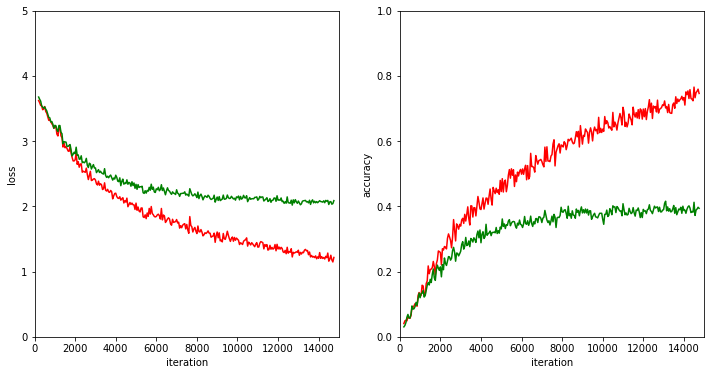

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,15000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,15000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model (6 conv layers, 2 dense layers)

In [12]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

Current validation loss:2.9406044483184814
Current validation accuracy:0.20348204672336578
Epoch:8
Iteration:1400
Time taken for the last 50 iterations: 55.648967266082764
Current training loss:2.691389322280884
Current training accuracy:0.24951171875
Current validation loss:2.861830711364746
Current validation accuracy:0.1904243677854538
Epoch:8
Iteration:1450
Time taken for the last 50 iterations: 57.17385697364807
Current training loss:2.5777246952056885
Current training accuracy:0.27685546875
Current validation loss:2.712226152420044
Current validation accuracy:0.2176278531551361
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 57.59930205345154
Current training loss:2.5537562370300293
Current training accuracy:0.2744140625
Current validation loss:2.758298397064209
Current validation accuracy:0.22306855022907257
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 56.935898303985596
Current training loss:2.6155190467834473
Current training accuracy:0.254882812

Current validation loss:2.2816429138183594
Current validation accuracy:0.341675728559494
Epoch:17
Iteration:3050
Time taken for the last 50 iterations: 56.109795808792114
Current training loss:1.5358973741531372
Current training accuracy:0.58056640625
Current validation loss:2.2460100650787354
Current validation accuracy:0.35908597707748413
Epoch:17
Iteration:3100
Time taken for the last 50 iterations: 57.71738576889038
Current training loss:1.5795413255691528
Current training accuracy:0.56591796875
Current validation loss:2.286604881286621
Current validation accuracy:0.33623504638671875
Epoch:18
Iteration:3150
Time taken for the last 50 iterations: 66.32919216156006
Current training loss:1.5275965929031372
Current training accuracy:0.5634765625
Current validation loss:2.2518973350524902
Current validation accuracy:0.33949944376945496
Epoch:18
Iteration:3200
Time taken for the last 50 iterations: 66.25120377540588
Current training loss:1.4287196397781372
Current training accuracy:0.617

Current training loss:0.7756423354148865
Current training accuracy:0.81103515625
Current validation loss:2.1700615882873535
Current validation accuracy:0.37649619579315186
Epoch:27
Iteration:4700
Time taken for the last 50 iterations: 44.72629761695862
Current training loss:0.8600322604179382
Current training accuracy:0.7880859375
Current validation loss:2.219318389892578
Current validation accuracy:0.36561480164527893
Epoch:27
Iteration:4750
Time taken for the last 50 iterations: 44.392462968826294
Current training loss:0.792952835559845
Current training accuracy:0.814453125
Current validation loss:2.1563408374786377
Current validation accuracy:0.3971708416938782
Epoch:27
Iteration:4800
Time taken for the last 50 iterations: 44.1614830493927
Current training loss:0.8484421372413635
Current training accuracy:0.78662109375
Current validation loss:2.212074041366577
Current validation accuracy:0.3982589840888977
Epoch:27
Iteration:4850
Time taken for the last 50 iterations: 44.66183304786

Epoch:36
Iteration:6300
Time taken for the last 50 iterations: 52.5115225315094
Current training loss:0.37816762924194336
Current training accuracy:0.93310546875
Current validation loss:2.106720447540283
Current validation accuracy:0.4113166630268097
Epoch:36
Iteration:6350
Time taken for the last 50 iterations: 51.927045822143555
Current training loss:0.3689750134944916
Current training accuracy:0.9326171875
Current validation loss:2.1456477642059326
Current validation accuracy:0.4178454875946045
Epoch:36
Iteration:6400
Time taken for the last 50 iterations: 51.97275948524475
Current training loss:0.3424761891365051
Current training accuracy:0.939453125
Current validation loss:2.1749558448791504
Current validation accuracy:0.41240477561950684
Epoch:37
Iteration:6450
Time taken for the last 50 iterations: 51.9051353931427
Current training loss:0.3507534861564636
Current training accuracy:0.9306640625
Current validation loss:2.160013437271118
Current validation accuracy:0.42655059695243

Current validation loss:2.212934970855713
Current validation accuracy:0.42328616976737976
Epoch:45
Iteration:7950
Time taken for the last 50 iterations: 51.767019271850586
Current training loss:0.18034982681274414
Current training accuracy:0.9716796875
Current validation loss:2.2257931232452393
Current validation accuracy:0.41349291801452637
Epoch:45
Iteration:8000
Time taken for the last 50 iterations: 51.506805658340454
Current training loss:0.18562723696231842
Current training accuracy:0.97802734375
Current validation loss:2.20089054107666
Current validation accuracy:0.43307942152023315
Epoch:46
Iteration:8050
Time taken for the last 50 iterations: 51.526073932647705
Current training loss:0.21000485122203827
Current training accuracy:0.9736328125
Current validation loss:2.293370485305786
Current validation accuracy:0.3949945569038391
Epoch:46
Iteration:8100
Time taken for the last 50 iterations: 51.9456148147583
Current training loss:0.1802128255367279
Current training accuracy:0.97

Current training loss:0.12290851771831512
Current training accuracy:0.98291015625
Current validation loss:2.3282406330108643
Current validation accuracy:0.4145810604095459
Epoch:55
Iteration:9600
Time taken for the last 50 iterations: 55.15662884712219
Current training loss:0.12058476358652115
Current training accuracy:0.98486328125
Current validation loss:2.291104316711426
Current validation accuracy:0.4254624545574188
Epoch:55
Iteration:9650
Time taken for the last 50 iterations: 54.47035837173462
Current training loss:0.11266292631626129
Current training accuracy:0.9892578125
Current validation loss:2.1967849731445312
Current validation accuracy:0.4439608156681061
Epoch:55
Iteration:9700
Time taken for the last 50 iterations: 51.42576622962952
Current training loss:0.11509508639574051
Current training accuracy:0.98681640625
Current validation loss:2.2909011840820312
Current validation accuracy:0.4178454875946045
Epoch:56
Iteration:9750
Time taken for the last 50 iterations: 51.34846

Epoch:64
Iteration:11200
Time taken for the last 50 iterations: 51.34511756896973
Current training loss:0.08186212182044983
Current training accuracy:0.990234375
Current validation loss:2.3476688861846924
Current validation accuracy:0.40914037823677063
Epoch:64
Iteration:11250
Time taken for the last 50 iterations: 51.674312114715576
Current training loss:0.07351789623498917
Current training accuracy:0.9951171875
Current validation loss:2.2998809814453125
Current validation accuracy:0.4254624545574188
Epoch:64
Iteration:11300
Time taken for the last 50 iterations: 51.6474723815918
Current training loss:0.09540257602930069
Current training accuracy:0.98974609375
Current validation loss:2.3543827533721924
Current validation accuracy:0.40587595105171204
Epoch:65
Iteration:11350
Time taken for the last 50 iterations: 51.470516204833984
Current training loss:0.07991588860750198
Current training accuracy:0.99560546875
Current validation loss:2.2349603176116943
Current validation accuracy:0.4

Current validation loss:2.3877580165863037
Current validation accuracy:0.4178454875946045
Epoch:73
Iteration:12850
Time taken for the last 50 iterations: 51.41552543640137
Current training loss:0.06445948779582977
Current training accuracy:0.99755859375
Current validation loss:2.3701119422912598
Current validation accuracy:0.4113166630268097
Epoch:74
Iteration:12900
Time taken for the last 50 iterations: 51.40084481239319
Current training loss:0.06802588701248169
Current training accuracy:0.99462890625
Current validation loss:2.41866397857666
Current validation accuracy:0.4211099147796631
Epoch:74
Iteration:12950
Time taken for the last 50 iterations: 51.58551573753357
Current training loss:0.06756589561700821
Current training accuracy:0.99365234375
Current validation loss:2.3794751167297363
Current validation accuracy:0.4254624545574188
Epoch:74
Iteration:13000
Time taken for the last 50 iterations: 51.62100601196289
Current training loss:0.049075257033109665
Current training accuracy

Current training loss:0.0489468015730381
Current training accuracy:0.99609375
Current validation loss:2.323636770248413
Current validation accuracy:0.41566920280456543
Epoch:83
Iteration:14500
Time taken for the last 50 iterations: 51.497503995895386
Current training loss:0.04834621772170067
Current training accuracy:0.99755859375
Current validation loss:2.463557481765747
Current validation accuracy:0.3971708416938782
Epoch:83
Iteration:14550
Time taken for the last 50 iterations: 51.608906984329224
Current training loss:0.04823322594165802
Current training accuracy:0.99609375
Current validation loss:2.3149397373199463
Current validation accuracy:0.4178454875946045
Epoch:83
Iteration:14600
Time taken for the last 50 iterations: 51.37788724899292
Current training loss:0.05129097029566765
Current training accuracy:0.99609375
Current validation loss:2.306786298751831
Current validation accuracy:0.42328616976737976
Epoch:84
Iteration:14650
Time taken for the last 50 iterations: 51.51153850

KeyboardInterrupt: 

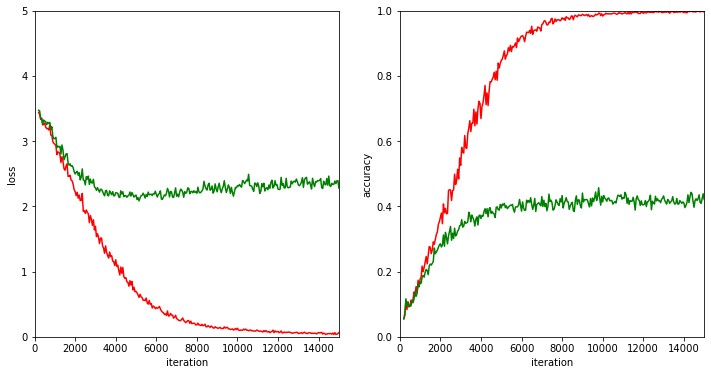

In [13]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,15000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,15000)
acc_graph.set_ylim(0,1)

plt.show() 

Another run with stronger weight decay.

In [14]:
model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

Current training loss:2.8239927291870117
Current training accuracy:0.19580078125
Current validation loss:2.9318482875823975
Current validation accuracy:0.17519041895866394
Epoch:8
Iteration:1400
Time taken for the last 50 iterations: 51.72453594207764
Current training loss:2.7767179012298584
Current training accuracy:0.2158203125
Current validation loss:2.935033082962036
Current validation accuracy:0.19477693736553192
Epoch:8
Iteration:1450
Time taken for the last 50 iterations: 56.2124400138855
Current training loss:2.6997194290161133
Current training accuracy:0.2509765625
Current validation loss:2.854092597961426
Current validation accuracy:0.23503808677196503
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 58.50908446311951
Current training loss:2.6686477661132812
Current training accuracy:0.2509765625
Current validation loss:2.764190912246704
Current validation accuracy:0.22633297741413116
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 54.88677382469177

Epoch:17
Iteration:3000
Time taken for the last 50 iterations: 50.08696246147156
Current training loss:1.9116473197937012
Current training accuracy:0.44287109375
Current validation loss:2.421320915222168
Current validation accuracy:0.3210010826587677
Epoch:17
Iteration:3050
Time taken for the last 50 iterations: 46.909117698669434
Current training loss:1.7484875917434692
Current training accuracy:0.5185546875
Current validation loss:2.3010826110839844
Current validation accuracy:0.3503808379173279
Epoch:17
Iteration:3100
Time taken for the last 50 iterations: 46.0157368183136
Current training loss:1.8076324462890625
Current training accuracy:0.46435546875
Current validation loss:2.3095057010650635
Current validation accuracy:0.341675728559494
Epoch:18
Iteration:3150
Time taken for the last 50 iterations: 51.24939322471619
Current training loss:1.7286077737808228
Current training accuracy:0.501953125
Current validation loss:2.289055347442627
Current validation accuracy:0.336235046386718

Epoch:26
Iteration:4650
Time taken for the last 50 iterations: 48.185044288635254
Current training loss:1.0451045036315918
Current training accuracy:0.72705078125
Current validation loss:2.1166834831237793
Current validation accuracy:0.41240477561950684
Epoch:27
Iteration:4700
Time taken for the last 50 iterations: 48.843687295913696
Current training loss:1.0262184143066406
Current training accuracy:0.7470703125
Current validation loss:2.1267642974853516
Current validation accuracy:0.3917301297187805
Epoch:27
Iteration:4750
Time taken for the last 50 iterations: 48.54933047294617
Current training loss:1.013572335243225
Current training accuracy:0.7451171875
Current validation loss:2.088000774383545
Current validation accuracy:0.38302502036094666
Epoch:27
Iteration:4800
Time taken for the last 50 iterations: 48.119791984558105
Current training loss:1.0074158906936646
Current training accuracy:0.7470703125
Current validation loss:2.1351945400238037
Current validation accuracy:0.406964093

Current validation loss:2.1192519664764404
Current validation accuracy:0.431991308927536
Epoch:36
Iteration:6300
Time taken for the last 50 iterations: 47.98954176902771
Current training loss:0.6317442655563354
Current training accuracy:0.87255859375
Current validation loss:2.1187705993652344
Current validation accuracy:0.41675734519958496
Epoch:36
Iteration:6350
Time taken for the last 50 iterations: 48.808550119400024
Current training loss:0.485934853553772
Current training accuracy:0.9033203125
Current validation loss:2.063581943511963
Current validation accuracy:0.43634384870529175
Epoch:36
Iteration:6400
Time taken for the last 50 iterations: 48.38893365859985
Current training loss:0.5608283877372742
Current training accuracy:0.88623046875
Current validation loss:2.058546781539917
Current validation accuracy:0.42219802737236023
Epoch:37
Iteration:6450
Time taken for the last 50 iterations: 48.181466579437256
Current training loss:0.5559262037277222
Current training accuracy:0.9008

Current training loss:0.3341063857078552
Current training accuracy:0.95458984375
Current validation loss:2.032160520553589
Current validation accuracy:0.42981502413749695
Epoch:45
Iteration:7950
Time taken for the last 50 iterations: 45.693262577056885
Current training loss:0.3395178020000458
Current training accuracy:0.94775390625
Current validation loss:2.1548702716827393
Current validation accuracy:0.418933629989624
Epoch:45
Iteration:8000
Time taken for the last 50 iterations: 46.563610553741455
Current training loss:0.38798800110816956
Current training accuracy:0.9296875
Current validation loss:2.1454782485961914
Current validation accuracy:0.41675734519958496
Epoch:46
Iteration:8050
Time taken for the last 50 iterations: 46.869319677352905
Current training loss:0.3524162769317627
Current training accuracy:0.94580078125
Current validation loss:2.134014129638672
Current validation accuracy:0.431991308927536
Epoch:46
Iteration:8100
Time taken for the last 50 iterations: 46.890501499

Epoch:54
Iteration:9550
Time taken for the last 50 iterations: 48.47827506065369
Current training loss:0.30493128299713135
Current training accuracy:0.95751953125
Current validation loss:2.160325288772583
Current validation accuracy:0.4276387393474579
Epoch:55
Iteration:9600
Time taken for the last 50 iterations: 49.480931997299194
Current training loss:0.24536414444446564
Current training accuracy:0.9677734375
Current validation loss:2.0902340412139893
Current validation accuracy:0.4287268817424774
Epoch:55
Iteration:9650
Time taken for the last 50 iterations: 49.01056742668152
Current training loss:0.2276950478553772
Current training accuracy:0.96630859375
Current validation loss:2.152808666229248
Current validation accuracy:0.4276387393474579
Epoch:55
Iteration:9700
Time taken for the last 50 iterations: 50.097495794296265
Current training loss:0.25478631258010864
Current training accuracy:0.9599609375
Current validation loss:2.173151969909668
Current validation accuracy:0.414581060

Current validation loss:2.2562968730926514
Current validation accuracy:0.42981502413749695
Epoch:64
Iteration:11200
Time taken for the last 50 iterations: 63.22997164726257
Current training loss:0.17693136632442474
Current training accuracy:0.9814453125
Current validation loss:2.1388158798217773
Current validation accuracy:0.4254624545574188
Epoch:64
Iteration:11250
Time taken for the last 50 iterations: 63.13013219833374
Current training loss:0.15210814774036407
Current training accuracy:0.98583984375
Current validation loss:2.128913402557373
Current validation accuracy:0.4309031665325165
Epoch:64
Iteration:11300
Time taken for the last 50 iterations: 63.73115372657776
Current training loss:0.18603545427322388
Current training accuracy:0.97900390625
Current validation loss:2.219482421875
Current validation accuracy:0.4113166630268097
Epoch:65
Iteration:11350
Time taken for the last 50 iterations: 64.7348153591156
Current training loss:0.1844225376844406
Current training accuracy:0.984

Current training loss:0.16100271046161652
Current training accuracy:0.990234375
Current validation loss:2.2520735263824463
Current validation accuracy:0.42002177238464355
Epoch:73
Iteration:12850
Time taken for the last 50 iterations: 104.03108930587769
Current training loss:0.1549869030714035
Current training accuracy:0.9892578125
Current validation loss:2.1181750297546387
Current validation accuracy:0.4341675639152527
Epoch:74
Iteration:12900
Time taken for the last 50 iterations: 105.305330991745
Current training loss:0.14267748594284058
Current training accuracy:0.98828125
Current validation loss:2.1412320137023926
Current validation accuracy:0.4276387393474579
Epoch:74
Iteration:12950
Time taken for the last 50 iterations: 106.93124485015869
Current training loss:0.11980650573968887
Current training accuracy:0.9912109375
Current validation loss:2.082282543182373
Current validation accuracy:0.4287268817424774
Epoch:74
Iteration:13000
Time taken for the last 50 iterations: 107.97703

Epoch:83
Iteration:14450
Time taken for the last 50 iterations: 173.48856806755066
Current training loss:0.11156730353832245
Current training accuracy:0.98681640625
Current validation loss:2.2468409538269043
Current validation accuracy:0.403699666261673
Epoch:83
Iteration:14500
Time taken for the last 50 iterations: 175.263334274292
Current training loss:0.10343685746192932
Current training accuracy:0.9921875
Current validation loss:2.159172534942627
Current validation accuracy:0.4243743121623993
Epoch:83
Iteration:14550
Time taken for the last 50 iterations: 177.05048727989197
Current training loss:0.11838249862194061
Current training accuracy:0.98974609375
Current validation loss:2.1453466415405273
Current validation accuracy:0.4406964182853699
Epoch:83
Iteration:14600
Time taken for the last 50 iterations: 178.3028757572174
Current training loss:0.10581906139850616
Current training accuracy:0.98974609375
Current validation loss:2.1549785137176514
Current validation accuracy:0.430903

KeyboardInterrupt: 

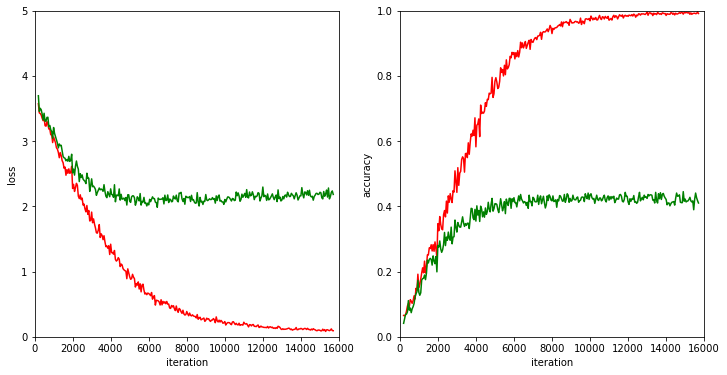

In [15]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,16000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,16000)
acc_graph.set_ylim(0,1)

plt.show() 

# 6 channels, des 2

In [4]:
class PetCNN6des2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370*3*3, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6des2()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN6des2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 

In [5]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 34.88352060317993
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 36.002455949783325
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 37.06289601325989
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 36.89603018760681
Current training loss:3.5033323764801025
Current training accuracy:0.05859375
Current validation loss:3.5588386058807373
Current validation accuracy:0.06746463477611542
Epoch:1
Iteration:250
Time taken for the last 50 iterations: 34.625619649887085
Current training loss:3.385882616043091
Current training accuracy:0.09765625
Current validation loss:3.4488658905029297
Current validation accuracy:0.07725788652896881
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 37.93877196311951
Current training loss:3.363849401473999
Current training accuracy:0.091796875
Current validation loss:3.375629186630249
Current validation accuracy:0.07508160918951035
Epoch:2
Iteration:35

Epoch:10
Iteration:1800
Time taken for the last 50 iterations: 37.91701340675354
Current training loss:2.468057870864868
Current training accuracy:0.310546875
Current validation loss:2.7188029289245605
Current validation accuracy:0.22850924730300903
Epoch:10
Iteration:1850
Time taken for the last 50 iterations: 38.02846384048462
Current training loss:2.3654587268829346
Current training accuracy:0.34326171875
Current validation loss:2.540800094604492
Current validation accuracy:0.2850925028324127
Epoch:10
Iteration:1900
Time taken for the last 50 iterations: 38.10046315193176
Current training loss:2.288755178451538
Current training accuracy:0.35595703125
Current validation loss:2.5502920150756836
Current validation accuracy:0.2752992510795593
Epoch:11
Iteration:1950
Time taken for the last 50 iterations: 37.97883152961731
Current training loss:2.402761697769165
Current training accuracy:0.322265625
Current validation loss:2.5860435962677
Current validation accuracy:0.27312296628952026
E

Epoch:19
Iteration:3450
Time taken for the last 50 iterations: 37.84905791282654
Current training loss:1.6460188627243042
Current training accuracy:0.548828125
Current validation loss:2.2749946117401123
Current validation accuracy:0.3373231887817383
Epoch:20
Iteration:3500
Time taken for the last 50 iterations: 37.70543122291565
Current training loss:1.6501836776733398
Current training accuracy:0.546875
Current validation loss:2.2945938110351562
Current validation accuracy:0.341675728559494
Epoch:20
Iteration:3550
Time taken for the last 50 iterations: 37.89128613471985
Current training loss:1.5787807703018188
Current training accuracy:0.56884765625
Current validation loss:2.2310006618499756
Current validation accuracy:0.3514689803123474
Epoch:20
Iteration:3600
Time taken for the last 50 iterations: 37.96059036254883
Current training loss:1.5792595148086548
Current training accuracy:0.55322265625
Current validation loss:2.2031354904174805
Current validation accuracy:0.3503808379173279


Epoch:29
Iteration:5100
Time taken for the last 50 iterations: 37.94946002960205
Current training loss:1.132077932357788
Current training accuracy:0.7119140625
Current validation loss:2.180981159210205
Current validation accuracy:0.37323176860809326
Epoch:29
Iteration:5150
Time taken for the last 50 iterations: 38.06389331817627
Current training loss:1.0819951295852661
Current training accuracy:0.7392578125
Current validation loss:2.200850486755371
Current validation accuracy:0.3819368779659271
Epoch:29
Iteration:5200
Time taken for the last 50 iterations: 38.00950574874878
Current training loss:0.9934301376342773
Current training accuracy:0.744140625
Current validation loss:2.1392035484313965
Current validation accuracy:0.390641987323761
Epoch:30
Iteration:5250
Time taken for the last 50 iterations: 37.88619303703308
Current training loss:1.0311142206192017
Current training accuracy:0.73583984375
Current validation loss:2.177990674972534
Current validation accuracy:0.38955387473106384

Epoch:38
Iteration:6750
Time taken for the last 50 iterations: 38.2719624042511
Current training loss:0.6254954934120178
Current training accuracy:0.87939453125
Current validation loss:2.1534793376922607
Current validation accuracy:0.40696409344673157
Epoch:39
Iteration:6800
Time taken for the last 50 iterations: 38.19490575790405
Current training loss:0.7615266442298889
Current training accuracy:0.83544921875
Current validation loss:2.1875574588775635
Current validation accuracy:0.3917301297187805
Epoch:39
Iteration:6850
Time taken for the last 50 iterations: 38.34522795677185
Current training loss:0.7239153981208801
Current training accuracy:0.833984375
Current validation loss:2.1980719566345215
Current validation accuracy:0.38955387473106384
Epoch:39
Iteration:6900
Time taken for the last 50 iterations: 38.182867765426636
Current training loss:0.6515406966209412
Current training accuracy:0.8701171875
Current validation loss:2.142364740371704
Current validation accuracy:0.40261152386

Current validation loss:2.183903455734253
Current validation accuracy:0.41675734519958496
Epoch:48
Iteration:8400
Time taken for the last 50 iterations: 40.32183289527893
Current training loss:0.538703203201294
Current training accuracy:0.8974609375
Current validation loss:2.1428236961364746
Current validation accuracy:0.41566920280456543
Epoch:48
Iteration:8450
Time taken for the last 50 iterations: 40.48021483421326
Current training loss:0.4475809335708618
Current training accuracy:0.93212890625
Current validation loss:2.2047641277313232
Current validation accuracy:0.40261152386665344
Epoch:48
Iteration:8500
Time taken for the last 50 iterations: 40.30946159362793
Current training loss:0.4846387505531311
Current training accuracy:0.908203125
Current validation loss:2.2083024978637695
Current validation accuracy:0.4113166630268097
Epoch:49
Iteration:8550
Time taken for the last 50 iterations: 40.38961172103882
Current training loss:0.502145528793335
Current training accuracy:0.8979492

KeyboardInterrupt: 

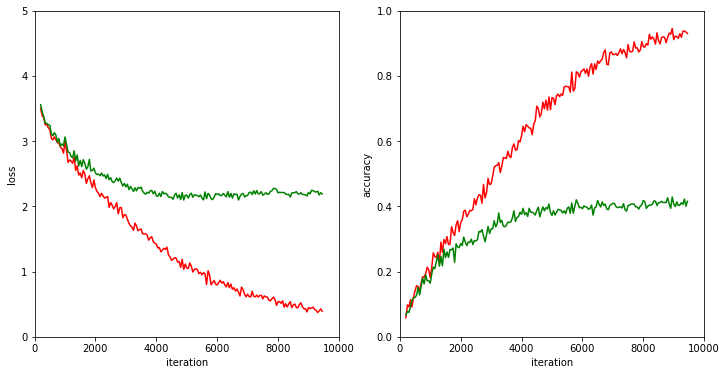

In [6]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,10000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,10000)
acc_graph.set_ylim(0,1)

plt.show() 